# Deploy ControlNet Canny Technique for Stable Diffusion on a SageMaker GPU Single-Model Endpoint

This notebook walks you through the deployment of a ControlNet tecnique with Stable Diffusion ona SageMaker GPU endpoint.<br/>
This notebook works well with the `PyTorch 2.0 Python 3.10 CPU Optimized` kernel on a SageMaker Studio `ml.t3.medium` instance.

# Background
With [ControlNet](https://huggingface.co/lllyasviel/ControlNet) we can control the generated images from Stable Diffusion models. There are various techniques of ControlNet, however, in this notebook we will show how to deploy the [Canny](https://huggingface.co/lllyasviel/sd-controlnet-canny) technique to a SageMaker endpoint

In [ ]:
!python -m pip install --upgrade pip --quiet
!pip install -U sagemaker --quiet
!pip install huggingface_hub --quiet
!pip install pillow --quiet
!pip install matplotlib --quiet

In [ ]:
!pip freeze | grep -E "huggingface|pillow|matplotlib|sagemaker|boto3|torch"

boto3 @ file:///home/conda/feedstock_root/build_artifacts/boto3_1683763173043/work
huggingface-hub==0.17.3
matplotlib @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1678135565516/work
matplotlib-inline @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-inline_1660814786464/work
Pillow @ file:///home/conda/feedstock_root/build_artifacts/pillow_1675487172403/work
sagemaker==2.193.0
sagemaker-experiments==0.1.43
sagemaker-pytorch-training==2.8.0
sagemaker-training==4.5.0
smdebug @ file:///tmp/sagemaker-debugger
torch==2.1.0
torchaudio==2.0.1
torchdata @ file:///opt/conda/conda-bld/torchdata_1679615656247/work
torchtext==0.15.1
torchvision==0.15.1


In [ ]:
import base64
import io
import json
import os
import shutil
import tarfile

from distutils.dir_util import copy_tree
from pathlib import Path

from PIL import Image
from huggingface_hub import snapshot_download

In [ ]:
import sagemaker
import boto3

sess = sagemaker.session.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.session.Session().region_name

display(role)
display(region)
display(bucket)

Creating directories to hold models and inference scripts

In [ ]:
import os

technique='canny'
os.makedirs(f'compressed/{technique}/', exist_ok=True)

The SageMaker inference toolkit is built on the multi-model server (MMS). MMS expects a [Python script](https://docs.aws.amazon.com/sagemaker/latest/dg/adapt-inference-container.html) that implements functions to load the model, pre-process input data, get predictions from the model, and process the output data in a model handler.
Here we write logic to load model under the `model_fn(model_dir)` function and logic to process the inference request under the `transform_fn(model, data, input_content_type, output_content_type)` function

In [ ]:
!pygmentize script/{technique}/inference.py | cat -n

     1	import cv2
     2	import numpy as np
     3	from PIL import Image
     4	import torch
     5	import json
     6	import os
     7	import io
     8	import base64
     9	from io import BytesIO
    10	from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DPMSolverMultistepScheduler, UniPCMultistepScheduler
    11	import boto3
    12	from pathlib import Path
    13	
    14	
    15	def _encode(image):
    16	    img = image
    17	    img_byte_arr = io.BytesIO()
    18	    img.save(img_byte_arr, format='PNG')
    19	    img_byte_arr = img_byte_arr.getvalue()
    20	    img_byte_arr = base64.b64encode(img_byte_arr).decode()
    21	    return img_byte_arr
    22	
    23	def _decode(image):
    24	    image = base64.b64decode(image)
    25	    image = Image.open(io.BytesIO(image))
    26	    return image
    27	
    28	
    29	# inference functions ---------------
    30	def model_fn(model_dir):
    31	
    32	    control_net_postfix=[
    33	            "canny",
    

Writing a `requirements.txt` file with all the dependencies needed. This would be installed by the SageMaker inference container. This would be in the same directory that holds the inference script. [SageMaker Inference Directory Structure](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#:~:text=If%20there%20are%20other%20packages,put%20in%20the%20same%20folder.)

In [ ]:
!pygmentize script/{technique}/requirements.txt | cat -n

     1	diffusers==0.21.4
     2	accelerate==0.23.0
     3	opencv-contrib-python==4.8.1.78
     4	controlnet-aux==0.0.7
     5	xformers==0.0.22.post4
     6	opencv-python-headless==4.8.1.78
     7	transformers==4.34.0


In [ ]:
%%time

model_id = ["runwayml/stable-diffusion-v1-5", "lllyasviel/sd-controlnet-canny"]

# Creating a tarfile to to compress our model to a `tar.gz` format as required by SageMaker
tar = tarfile.open(f"compressed/{technique}/{technique}.tar.gz", "w:gz", compresslevel=2)
for ids in model_id:
    # Create local dir to download models into
    model_tar_dir = Path(ids.split("/")[-1])
    if model_tar_dir.exists():
        shutil.rmtree(str(model_tar_dir))
    model_tar_dir.mkdir(exist_ok=True)
    name = ids.split('-',2)[-1]

    # unwanted checkpoint files in sdv1.5 to reduce weight of model
    unwanted_files_sd=["v1-5-pruned-emaonly.safetensors", "*ckpt", "v1-5-pruned.safetensors", "v1-inference.yaml"]

    # Download model from Hugging Face into model_dir and adding to the tarfile then deleting from local directory
    if ids == "runwayml/stable-diffusion-v1-5":
        snapshot_download(ids, local_dir=str(model_tar_dir), local_dir_use_symlinks=False, ignore_patterns=unwanted_files_sd)
        tar.add(str(model_tar_dir), arcname=f"{name}")
        # !rm -r {str(model_tar_dir)}
    else:
        snapshot_download(ids, local_dir=str(model_tar_dir), local_dir_use_symlinks=False)
        tar.add(str(model_tar_dir), arcname=name)
        # !rm -r {str(model_tar_dir)}

# Adding the inference scripts and requirements file to the tarfile
tar.add(f"script/{technique}/", arcname='code')
tar.close()

Copy the compressed model artiact to S3

In [ ]:
model_s3_uri = f"s3://{bucket}/model_controlnet/{technique}.tar.gz"
!aws s3 cp compressed/{technique}/{technique}.tar.gz {model_s3_uri}

Configuring the Endpoint. Here we use the HuggingFace Pytorch framework container for inference

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.utils import name_from_base

# create Hugging Face Model Class
image_uri ="763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:2.0.0-transformers4.28.1-gpu-py310-cu118-ubuntu20.04"

model_name = name_from_base("controlnet-canny")

huggingface_model = HuggingFaceModel(
   model_data=model_s3_uri,  # path to your trained sagemaker model
   role=role, # iam role with permissions to create an Endpoint
   py_version="py310", # python version of the DLC
   image_uri=image_uri, # sagemaker container image uri,
   env={
        "MMS_MAX_RESPONSE_SIZE": "20000000",
        "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
        "SAGEMAKER_PROGRAM": "inference.py",
        "SAGEMAKER_REGION": "us-east-1",
        "SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/code",
   },
   name=model_name,
)

huggingface_model.name

Deploy model to an endpoint

In [ ]:
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
from sagemaker.s3 import s3_path_join

# create async endpoint configuration
async_config = AsyncInferenceConfig(
    output_path=s3_path_join("s3://", bucket, "controlnet_async_inference/output"), # Where our results will be stored
    # Add nofitication SNS if needed
    notification_config={
        # "SuccessTopic": "PUT YOUR SUCCESS SNS TOPIC ARN",
        # "ErrorTopic": "PUT YOUR ERROR SNS TOPIC ARN",
    }
)

print(f"Output Path: {async_config.output_path}")
print(f"Failure Path: {async_config.failure_path}")

In [ ]:
%%time

async_endpoint_name = name_from_base("controlnet-canny-async")
instance_type = "ml.g4dn.2xlarge" # 32 GiB Mem / NVIDIA T4 Tensor Core GPU

# deploy the endpoint endpoint
async_predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    async_inference_config=async_config,
    endpoint_name=async_endpoint_name
)

async_predictor.endpoint_name

----------------!CPU times: user 249 ms, sys: 23.7 ms, total: 272 ms
Wall time: 8min 35s


'controlnet-canny-async-2023-10-19-01-29-22-293'

Reading input file and creating prompt

In [ ]:
import base64

with open(r"sportscar.jpeg", "rb") as img:
    image = base64.b64encode(img.read())

p_p = "metal orange colored car, complete car, colour photo, outdoors in a pleasant landscape, realistic, high quality"
n_p = "cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, blurry, bad proportions"

request = {
    "prompt": p_p,
    "negative_prompt": n_p,
    "image": image.decode(),
    "scale": 0.5,
    "steps": 20,
    "low_threshold": 100,
    "high_threshold": 200,
    "seed": 123
}

Running inference by passing the payload to the endpoint

In [ ]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

async_predictor.serializer = JSONSerializer()
async_predictor.deserializer = JSONDeserializer()

In [ ]:
async_response = async_predictor.predict_async(data=request,
                                               initial_args={
                                                   'InvocationTimeoutSeconds': 3600
                                               })
output_location = async_response.output_path
output_location

In [ ]:
%%time
from sagemaker.async_inference.waiter_config import WaiterConfig

waiter_config = WaiterConfig(max_attempts=120, delay=15) # wait for 30 minutes
output = async_response.get_result(waiter_config=waiter_config)

CPU times: user 3.82 s, sys: 200 ms, total: 4.02 s
Wall time: 18min 6s


In [ ]:
from PIL import Image
import io

def _decode(image):
    image = base64.b64decode(image)
    image = Image.open(io.BytesIO(image))
    return image

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

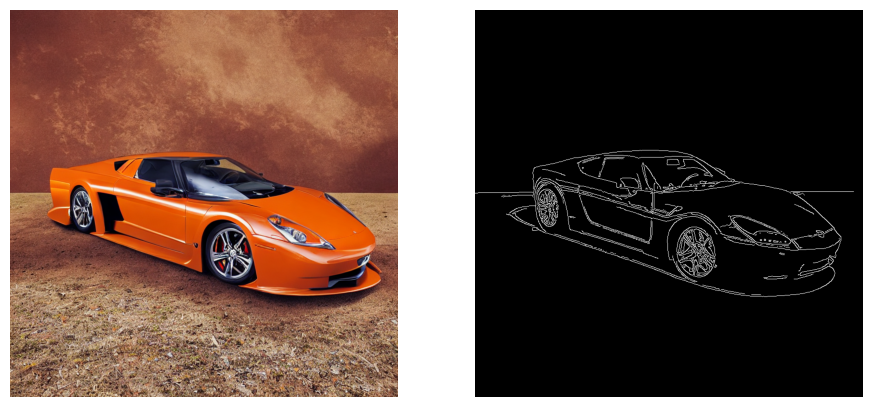

In [ ]:
%matplotlib inline

rcParams['figure.figsize'] = 11, 8

image = _decode(output["output_image"])
image_canny=_decode(output["canny_image"])

fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].imshow(image)
ax[1].imshow(image_canny)

### References

- [1] [Amazon SageMaker Asynchronous Inference using the SageMaker Python SDK](https://github.com/aws/amazon-sagemaker-examples/blob/main/async-inference/Async-Inference-Walkthrough-SageMaker-Python-SDK.ipynb)
- [2] [Deploy all options with Amazon SageMaker XGBoost.ipynb](https://github.com/aws/amazon-sagemaker-examples/blob/main/inference/structured/async/default_server/single_model/deploy_all_options_xgb.ipynb)
- [3] [SageMaker Asynchronous Inference Examples](https://github.com/aws/amazon-sagemaker-examples/tree/main/inference)
- [4] SageMaker Python SDK Guide - sagemaker.predictor_async.[AsyncPredictor.predict_async(data=None, input_path=None, initial_args=None, inference_id=None)](https://sagemaker.readthedocs.io/en/stable/api/inference/predictor_async.html#sagemaker.predictor_async.AsyncPredictor.predict_async)
- [5] Boto3 Reference Guide - SageMakerRuntime.Client.[invoke_endpoint_async(**kwargs)](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker-runtime/client/invoke_endpoint_async.html)